In [99]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

col_names = ["func", "start", "end", "filename", "worker", "thread", "process"]

In [152]:
def avg_func_time(folder):
    pd_list = [pd.read_csv(filename, names=col_names) for filename in glob.glob(folder)]
    df = pd.concat(pd_list, axis=0, ignore_index=True)
    df["runtime"] = df.end - df.start
    return df.groupby("func").mean()["runtime"]

def func_count(folder):
    pd_list = [pd.read_csv(filename, names=col_names) for filename in glob.glob(folder)]
    df = pd.concat(pd_list, axis=0, ignore_index=True)
    return df.groupby("func").count()["filename"]

def thread_count(folder):
    pd_list = [pd.read_csv(filename, names=col_names) for filename in glob.glob(folder)]
    df = pd.concat(pd_list, axis=0, ignore_index=True)
    return df.groupby("func").nunique()[
        ("process" if "spark" in folder else "thread")
    ]

def concurrent_threads(folder, granularity=10):
    thread = "process" if "spark" in folder  else "thread"
    def func_(filename):
        df = pd.read_csv(filename, names=col_names)

        df["active"] = df.apply(lambda x:list(np.linspace(round(x.start), round(x.end), granularity)), axis=1)
        df = df.explode("active")

        return df.groupby(["active", thread]).count() \
            .reset_index(thread).groupby(["active"]).count()
    
    for filename in glob.glob(folder):
        print(filename)

        rv = func_(filename)
        rv.reset_index().plot.scatter("active", thread, s=5)
        plt.show()
        pprint(rv[thread].describe())

In [8]:
folder = "../results/benchmarks/spark:increment:n_worker=4:block_size=2500:iterations=5:delay=1.0/*"
avg_func_time(folder), func_count(folder), thread_count(folder)

(func
 dump          3.318289
 increment     1.032687
 load         10.730773
 Name: runtime, dtype: float64,
 func
 dump          25000
 increment    125000
 load          25000
 Name: filename, dtype: int64,
 func
 dump         2560
 increment    2560
 load         2560
 Name: process, dtype: int64)

In [9]:
folder = "../results/benchmarks/dask:increment:n_worker=4:block_size=2500:iterations=5:delay=1.0/*"
avg_func_time(folder), func_count(folder), thread_count(folder)

(func
 dump         3.205098
 increment    1.040816
 load         9.750303
 Name: runtime, dtype: float64,
 func
 dump          25000
 increment    125000
 load          25000
 Name: filename, dtype: int64,
 func
 dump         2558
 increment    2560
 load         2560
 Name: thread, dtype: int64)

# Spark concurrent process

../ccpe-debug-numbagil/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/summary-1f227b88-8f83-11ec-b5d3-4cd98faa323f.csv


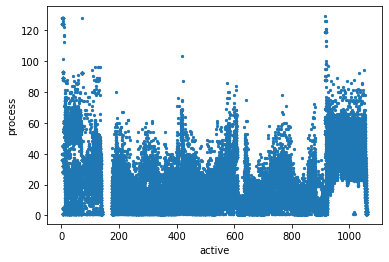

count    100556.000000
mean         18.864832
std          15.322078
min           1.000000
25%           7.000000
50%          14.000000
75%          27.000000
max         129.000000
Name: process, dtype: float64


In [166]:
folder = "../ccpe-debug-numbagil/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder, 100)

../ccpe-debug-32threads/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/summary-63969bc3-8eb2-11ec-b9a8-4cd98faa323f.csv


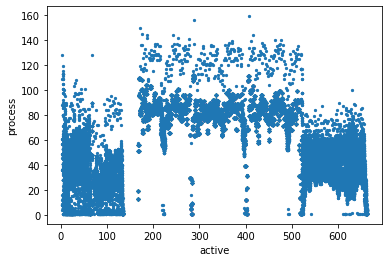

count    62443.000000
mean        60.173935
std         28.249471
min          1.000000
25%         33.000000
50%         68.000000
75%         85.000000
max        159.000000
Name: process, dtype: float64


In [167]:
folder = "../ccpe-debug-32threads/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder, 100)

../ccpe-debug-64threads/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/summary-5d1d8859-8f8d-11ec-ba0d-4cd98faa323f.csv


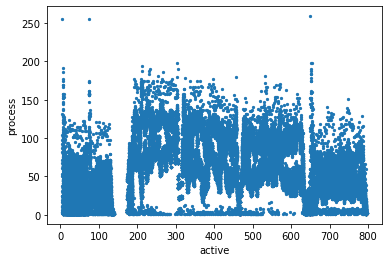

count    76260.000000
mean        57.018083
std         33.728668
min          1.000000
25%         32.000000
50%         52.000000
75%         80.000000
max        259.000000
Name: process, dtype: float64


In [169]:
folder = "../ccpe-debug-64threads/benchmarks/spark:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder, 100)

# Dask concurrent thread

../ccpe-debug-32threads/benchmarks/dask:kmeans:n_worker=4:block_size=5000:iterations=3/summary-18c3e560-8ea9-11ec-8e82-4cd98faa323f.csv


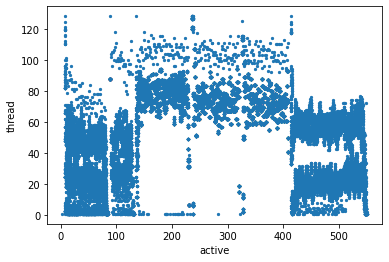

count    52172.000000
mean        53.140401
std         26.315434
min          1.000000
25%         26.000000
50%         60.000000
75%         75.000000
max        128.000000
Name: thread, dtype: float64


In [168]:
folder = "../ccpe-debug-32threads/benchmarks/dask:kmeans:n_worker=4:block_size=5000:iterations=3/*"
concurrent_threads(folder, 100)

# Test for concurrent thread function

In [144]:
df = pd.concat([pd.DataFrame({"start": np.arange(0, 1000, x)}).assign(base = x) for x in [1, 2, 3, 5]])

df["active"] = df.apply(lambda x:list(np.linspace(round(x.start), round(x.start), 1)), axis=1)
df = df.explode("active")

rv = df.groupby(["active", "base"]).count() \
    .reset_index("base").groupby(["active"]).count()

out_data = rv.base.values
for i in range(1000):
    count = 1
    if i % 2 == 0:
        count += 1
    if i % 3 == 0:
        count += 1
    if i % 5 == 0:
        count += 1
        
    assert count == out_data[i]